# Simple "neural net" example

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'

In [2]:
import numpy as np
import scipy.signal
import resonance.db
import resonance.si
import resonance.run
import resonance.cross
import resonance.pipe

import keras.models
import keras.layers

# some extra tools
import matplotlib.pyplot as plt
import collections

Using Theano backend.


We will need to have some data to train and test, let's define a generator function for it

In [3]:
GeneratedData = collections.namedtuple('GeneratedData', 'data data_times events events_times stream_info')

def generate_some_data(duration_in_seconds):
    sampling_rate = 250
    saw_frequency = 3
    block_size = 50

    nanoseconds = 1e9

    # create stream info definitions
    c_si = resonance.si.Channels(1, sampling_rate)
    e_si = resonance.si.Event()

    def data_generator(timestamp):
        times = np.linspace(timestamp - block_size / sampling_rate, timestamp, block_size)
        saw = scipy.signal.sawtooth(times * 2 * np.pi * saw_frequency)

        rand = np.random.randn(block_size) * .2 - .1

        if int(timestamp) % 2:
            signal = rand
        else:
            signal = rand + saw

        return signal

    data_blocks_end_times = block_end_times = np.arange(1, duration_in_seconds+1, block_size/sampling_rate)   # start from second 1
    data_blocks = [
        resonance.db.Channels(
            c_si,
            timestamp * nanoseconds,  # resonance operate in nanoseconds internally
            data_generator(timestamp)
        )
        for timestamp in block_end_times
    ]

    event_times = np.linspace(1, duration_in_seconds, duration_in_seconds)+.5
    event_blocks = [
        resonance.db.Event(
            e_si,
            timestamp * nanoseconds,
            'Saw off' if int(timestamp) % 2 else 'Saw on'
        )
        for timestamp in event_times
    ]
    return GeneratedData(data_blocks, data_blocks_end_times, event_blocks, event_times, (c_si, e_si))


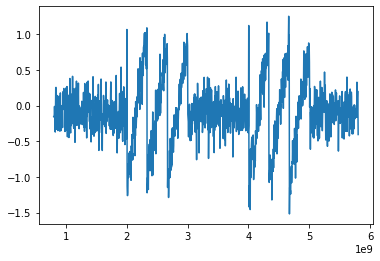

In [4]:
# Let's see what is inside the data
demo_set = generate_some_data(5)

demo_data = resonance.db.combine(*demo_set.data) # combine all data block in one big block
plt.plot(demo_data.TS, demo_data)


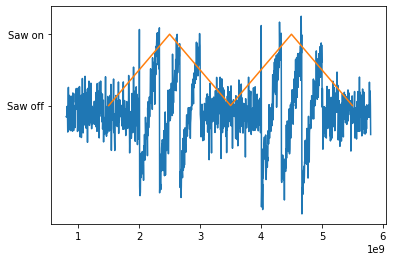

In [5]:
# And events:
demo_events = resonance.db.combine(*demo_set.events)
plt.plot(demo_data.TS, demo_data, demo_events.TS, demo_events)
# Not super professional look but showes the point

In [6]:
# it is better to simulate real life data stream when data and events arrives interleaved
def reorder_data(dataset): # @todo: this should be part of the package
    all_blocks = np.asarray([*dataset.data, *dataset.events], dtype=object)
    all_ts = np.concatenate((dataset.data_times, dataset.events_times))
    permute = np.argsort(all_ts)
    return all_blocks[permute]

In [7]:
window_size = 120
window_offset = -60 # +-60 samples around event

def training_schema():
    eeg = resonance.input(0)
    events = resonance.input(1)
    
    windows = resonance.cross.windowize_by_events(eeg, events, window_size, window_offset)
    
    resonance.createOutput(windows, "windows")
    

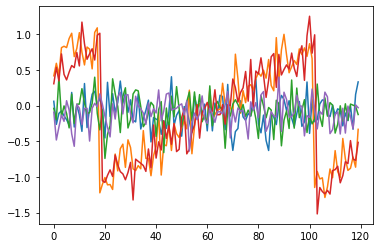

In [8]:
result = resonance.run.online(demo_set.stream_info, reorder_data(demo_set), training_schema)

ax = plt.axes()
for block in result['windows']:
    ax.plot(block)

In [9]:
# Nice to know is that windowize_by_events populate metadata field of windows
[block.metadata for block in result['windows']]

[Event(['Saw off'], dtype=object),
 Event(['Saw on'], dtype=object),
 Event(['Saw off'], dtype=object),
 Event(['Saw on'], dtype=object),
 Event(['Saw off'], dtype=object)]

## Let's classify the data

In [10]:
training_data = generate_some_data(60)
training_data = resonance.run.online(training_data.stream_info, reorder_data(training_data), training_schema)

train_input = np.transpose(np.concatenate(training_data['windows'], axis=1))
train_output = [block.metadata=='Saw on' for block in training_data['windows']]


In [11]:
# proudly copied from internets, no-brainer, just for demonstration
model = keras.models.Sequential()
model.add(keras.layers.Dense(12, input_dim=train_input[0].shape[0], activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_input, train_output, epochs=100, batch_size=10)
_, accuracy = model.evaluate(train_input, train_output)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/100
60/60 [==============================] - 0s 72us/step - loss: 0.5758 - accuracy: 0.5667
Epoch 2/100
60/60 [==============================] - 0s 73us/step - loss: 0.4783 - accuracy: 0.6167
Epoch 3/100
60/60 [==============================] - 0s 132us/step - loss: 0.4205 - accuracy: 0.6667
Epoch 4/100
60/60 [==============================] - 0s 84us/step - loss: 0.3843 - accuracy: 0.8000
Epoch 5/100
60/60 [==============================] - 0s 73us/step - loss: 0.3555 - accuracy: 0.8000
Epoch 6/100
60/60 [==============================] - 0s 77us/step - loss: 0.3302 - accuracy: 0.8833
Epoch 7/100
60/60 [==============================] - 0s 117us/step - loss: 0.3096 - accuracy: 0.9333
Epoch 8/100
60/60 [==============================] - 0s 109us/step - loss: 0.2881 - accuracy: 0.9833
Epoch 9/100
60/60 [==============================] - 0s 106us/step - loss: 0.2668 - accuracy: 1.0000
Epoch 10/100
60/60 [==============================] - 0s 99us/step - loss: 0.2453 - accuracy: 1.

60/60 [==============================] - 0s 77us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 82/100
60/60 [==============================] - 0s 63us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 83/100
60/60 [==============================] - 0s 69us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 84/100
60/60 [==============================] - 0s 61us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 85/100
60/60 [==============================] - 0s 104us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 86/100
60/60 [==============================] - 0s 83us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 87/100
60/60 [==============================] - 0s 90us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 88/100
60/60 [==============================] - 0s 61us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 89/100
60/60 [==============================] - 0s 70us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 90/100
60/60 [==============================] - 0s 93us/step - loss: 0.0011 - accuracy: 1.0000
Ep

## Now let's run the model

In [12]:
def classification_schema():
    eeg = resonance.input(0)
    events = resonance.input(1)
    
    windows = resonance.cross.windowize_by_events(eeg, events, window_size, window_offset)
    
    def run_classifier(window):
        return model.predict(np.transpose(window))[0,0]
    
    classified = resonance.pipe.transform_to_event(windows, run_classifier)
    
    resonance.createOutput(classified, "classified")

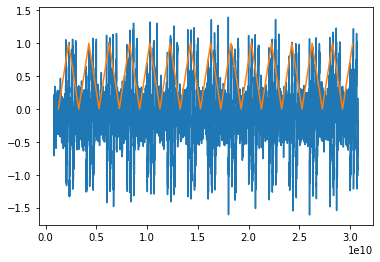

In [13]:
test_data = generate_some_data(30)
classification_result = resonance.run.online(test_data.stream_info, reorder_data(test_data), classification_schema)

classified = classification_result['classified']


test_signal = resonance.db.combine(*test_data.data) 
ax = plt.axes()
ax.plot(test_signal.TS, test_signal)
ax.plot(classified.TS, classified)
